<h1><big><center>Probabilistic Graphical Models - HW2</center></big></h1>
<center>
**Names**: Jean-Christophe CORVISIER - Mohammed Amine KHELDOUNI
</center>
<center>
**Emails**: jean-christophe.corvisier@eleves.enpc.fr - mkheldou@ens-paris-saclay.fr
</center>

In [30]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import copy

# Utils
link_of_path = r"./classification_data_HWK2/"
colors = "bgrmcykw"

def distCentroids(X,mu):
    return np.sum((mu-X)*(mu-X),axis=1)

def getDistortion(X, mu, labels, k):
    distortionMeasure = 0
    for j in range(X.shape[0]):
        distortionMeasure += distCentroids(X[j,:],mu)[int(labels[j])]
    return distortionMeasure

In [31]:
class LearnClustering:
    def __init__(self, d=2, k=4, dataLabel="EMGaussian"):
        self.k = k
        self.d = d
        self.fileTrain = pd.read_csv(os.path.join(link_of_path, dataLabel+".data"), sep=" ", header = None)
        self.fileTest = pd.read_csv(os.path.join(link_of_path, dataLabel+".test"), sep=" ", header = None)
        self.Xtrain = self.fileTrain[[0,1]]
        self.Xtest = self.fileTest[[0,1]]
        self.Xt = np.asarray(self.Xtrain).reshape(self.Xtrain.shape[0], self.d)
        self.Xv = np.asarray(self.Xtest).reshape(self.Xtest.shape[0], self.d)
    
    def kmeans(self, X, eps=10e-20, Niter=1000):
        n = X.shape[0]
        mu = np.random.rand(self.k,self.d)
        tmp_mu = mu
        labels = np.zeros((n,1))
        diff = 5*eps
        counter = 0
        distortions = []
        while (counter < Niter and np.any(diff >= eps)):
            tmp_mu = mu.copy()
            for i in range(n):
                labels[i] = np.argmin(distCentroids(X[i,:],mu))
            for j in range(self.k):
                mu[j,:] = np.sum(X * (labels == j), axis=0) / (np.sum(labels == j, axis=0)+eps)
            diff = np.sum((tmp_mu-mu)*(tmp_mu-mu), axis=1)
            counter += 1
            distortions.append(getDistortion(X, mu, labels, self.k))
        # Calculating the cost function (distortion measure)
        return mu, labels, distortions
    
    def kmeansClusteringPlot(self, X):
        mu, labels, distortions = self.kmeans(X)
        print("Final distortion measure for the K-means algorithm: ", distortions[-1])
        
        # Plotting the distortion measure for K-means
        plt.figure(figsize=(16,8))
        plt.plot(range(len(distortions)), distortions, color = 'green', linewidth=2)
        plt.xlabel("Iterations", fontsize=16)
        plt.ylabel("Distortion measure of the K-means algorithm", fontsize=16)
        plt.show()
        
        # Plotting distortion histogram for multiple random K-means iterations
        distortionsHist = []
        for i in range(100):
            mu, labels, distortions = self.kmeans(X)
            distortionsHist.append(distortions[-1])
        plt.figure(figsize=(16,8))
        plt.hist(distortionsHist)
        plt.xlabel("Distortion values", fontsize=16)
        plt.ylabel("Distortion histogram", fontsize=16)
        plt.show()
        
        # Plotting the clustering result for K-means algorithm
        plt.figure(figsize=(16,8))
        for i in range(self.k):
            if (i==0):
                ax = pd.DataFrame(X)[labels==i].plot(kind='scatter', x=0,y=1, c=colors[i], figsize = (16,8), label = "Cluster " + str(i+1))
            else:
                pd.DataFrame(X)[labels==i].plot(kind='scatter', x=0,y=1, c=colors[i], figsize = (16,8), ax=ax, label = "Cluster " + str(i+1))
            plt.scatter(mu[i,0], mu[i,1], edgecolors=colors[i], linewidths = 10, marker='*', label = "Centroid for label " + str(i+1))
        plt.xlabel("Data first feature", fontsize=16)
        plt.ylabel("Data second feature", fontsize=16)
        plt.legend(loc=2, scatterpoints = 1)
        plt.show()
    
    def likelihood(self, X, theta):
        """ This function computes the Expected complete log-likelihood """
        [alpha, mu, sigma] = theta
        normal = np.zeros((X.shape[0],self.k))
        alpha = np.array(alpha)
        for j in range(self.k):
            normal[:,j] = 1./((2*np.pi)**(self.d/2)*np.sqrt(np.linalg.det(sigma[j]))) * np.exp(-0.5*np.sum((X-mu[j]).dot(np.linalg.inv(sigma[j]))*(X-mu[j]), axis=1))

        tau = self.computeTau(X, theta)
        L = np.multiply(tau, np.log(normal+1e-20)) + np.multiply(tau, np.log(alpha+1e-20))
        return np.sum(L)


    def computeTau(self, X, theta):
        """
        inputs: X (Nx2) matrix of data we want to classify into k clusters
        theta: the parameters of the model. For a GMM, we have theta = [alpha, mu, sigma]
        outputs: tau (Nxk) matrix of probability distribution of z|x,theta 
        following the course notation.
        """
        [alpha, mu, sigma] = theta
        # E-step
        tau_tilde = np.zeros((X.shape[0],self.k))
        for j in range(self.k):
            tau_tilde[:,j] = alpha[j]/((2*np.pi)**(self.d/2)*np.sqrt(np.linalg.det(sigma[j]))) * np.exp(-0.5*np.sum((X-mu[j]).dot(np.linalg.inv(sigma[j]))*(X-mu[j]), axis=1))

        tau = np.divide(tau_tilde,np.sum(tau_tilde,axis=1).reshape(tau_tilde.shape[0],1))
        return tau
    
    
    def trainEM(self, X, theta_init, Niter=100):
        """ This function output the optimal parameters by running an EM algorithm
        and computing the estimators of our Gaussian Mixtures Model.
        """
        counter = 0
        [alpha, mu, sigma] = theta_init
        n = X.shape[0]
        likelihoods = []
        while(counter < Niter):
            # E-step
            tau = self.computeTau(X,[alpha, mu, sigma])
            likelihoods.append(self.likelihood(X, [alpha, mu, sigma]))
            # M-step
            alpha = np.sum(tau, axis=0) / np.sum(tau)
            for j in range(self.k):
                mu[j] = np.sum(tau[:,j].reshape(n,1)*X,axis=0)/np.sum(tau[:,j])
                sigma[j] = (X-mu[j]).transpose().dot(tau[:,j].reshape(X.shape[0],1)*(X-mu[j]))/np.sum(tau[:,j])

            counter += 1

        theta = [alpha, mu, sigma]

        return theta, likelihoods
    
    def trainIsotropicEM(self, X, theta_init, Niter=500):
        """ This function output the optimal parameters by running an EM algorithm
        and computing the estimators of our Gaussian Mixtures Model, when the covariance
        matrices are proportional to the identity matrix (covarianceMatrix = lbd* Identity)
        """
        counter = 0
        [alpha, mu, sigma] = theta_init
        n = X.shape[0]
        likelihoods = []
        while(counter < Niter):
            # E-step 
            tau = self.computeTau(X, [alpha, mu, sigma])
            # M-step
            alpha = np.sum(tau, axis=0) / np.sum(tau)
            for j in range(self.k):
                mu[j] = np.sum(tau[:,j].reshape(n,1)*X,axis=0)/np.sum(tau[:,j])
                lbd = 1./self.d * np.sum(np.multiply(tau[:,j], np.sum((X-mu[j])*(X-mu[j]), axis=1)))/np.sum(tau[:,j])
                sigma[j] = lbd * np.eye(X.shape[1])
            counter += 1
            likelihoods.append(self.likelihood(X, [alpha, mu, sigma]))

        theta = [alpha, mu, sigma]
        return theta, likelihoods
    
    def predictEM(self, X, theta_opt):
        tau = self.computeTau(X, theta_opt)
        Z = np.argmax(tau, axis=1)
        return Z.reshape(-1,1)

    def score(self, X, theta_opt, labels):
        return np.sum(self.predictEM(X, theta_opt) == labels.reshape(-1,1))/len(labels)
    
    
    def plotPrediction(self, X, theta_opt):
        """ This function plots the considered data with their respective labels (colors).
            Moreover, it displays the level sets for the gaussian distributions found by the
            EM algorithm, their centroids (means) and their variances.
        """
        [alpha, mu, sigma] = theta_opt
        labels = self.predictEM(X, theta_opt)
        mesh_n = 500
        xx, yy = np.meshgrid(np.linspace(-10, 10, mesh_n), np.linspace(-10, 10, mesh_n))
        XX = np.zeros((mesh_n*mesh_n, 2))
        XX[:,0] = xx.flatten()
        XX[:,1] = yy.flatten()

        tau = self.computeTau(XX, theta_opt)
        plt.figure(figsize=(20,10))
        for i in range(self.k):
            if (i==0):
                ax = pd.DataFrame(X)[labels==i].plot(kind='scatter', x=0,y=1, c=colors[i], figsize = (20,10), label="Cluster " + str(i+1))
            else:
                pd.DataFrame(X)[labels==i].plot(kind='scatter', x=0,y=1, c=colors[i], figsize = (20,10), ax=ax, label="Cluster " + str(i+1))
            plt.scatter(mu[i,0], mu[i,1], edgecolors=colors[i], linewidths = 10, marker='*')
            zz = 1./(2*np.pi*np.sqrt(np.linalg.det(sigma[i]))) * np.exp(-0.5*np.sum((XX-mu[i]).dot(np.linalg.inv(sigma[i]))*(XX-mu[i]), axis=1))
            zz = zz.reshape(mesh_n,mesh_n)
            plt.contour(xx, yy, zz, linewidths=2, colors=colors[i], label="Distribution mass for cluster " + str(i+1))
        plt.xlabel("Data first feature", fontsize=18)
        plt.ylabel("Data second feature", fontsize=18)
        plt.legend(loc=2, scatterpoints = 1)
        plt.show()

Final distortion measure for the K-means algorithm:  3240.59302475


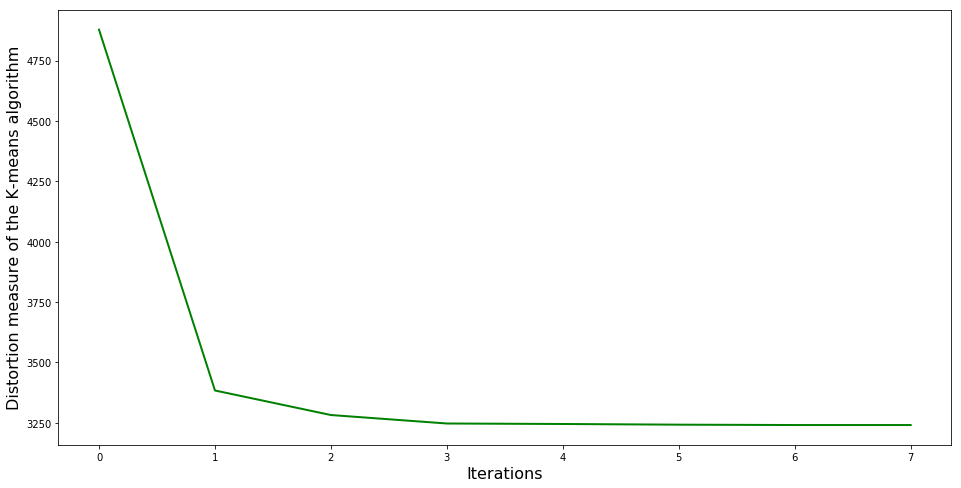

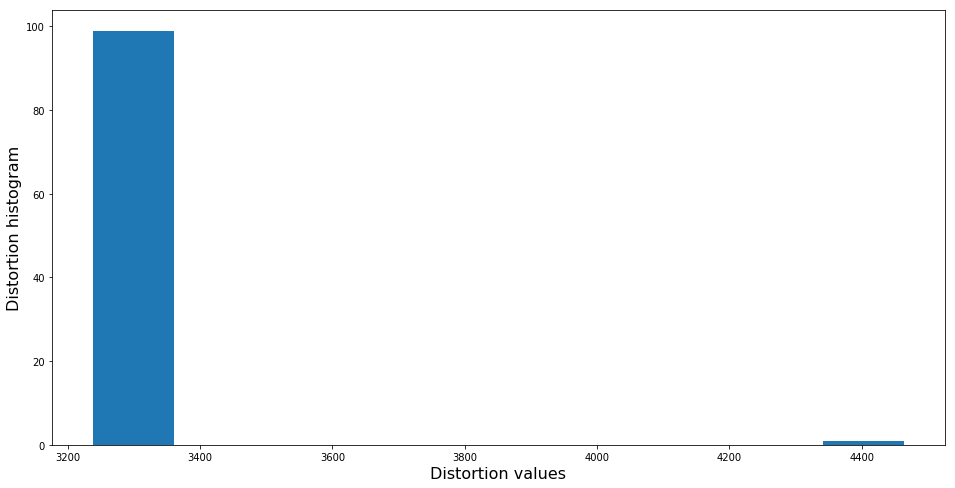

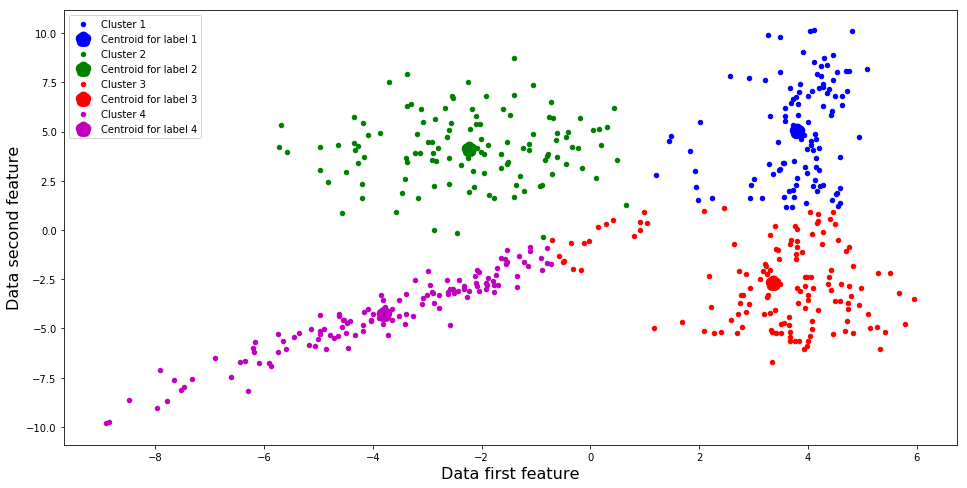

In [32]:
model = LearnClustering()
mu, labels, distortion = model.kmeans(model.Xt)
model.kmeansClusteringPlot(model.Xt)

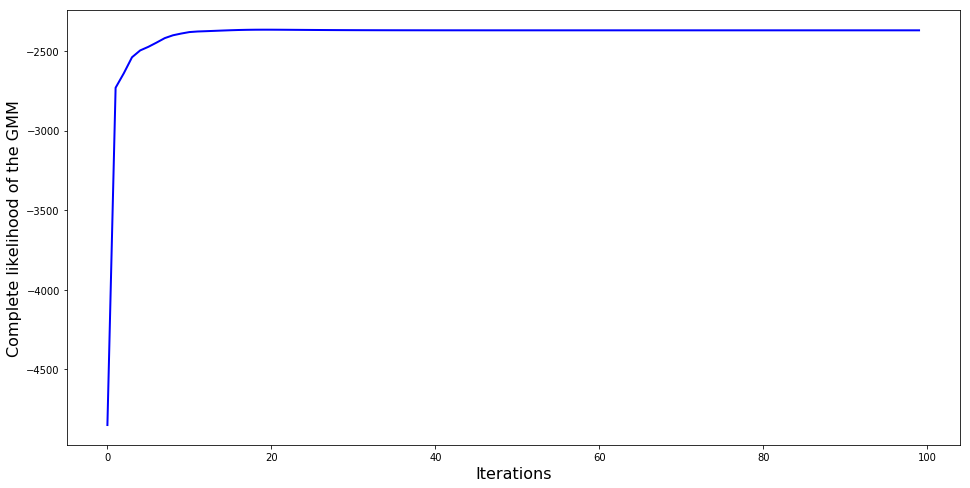

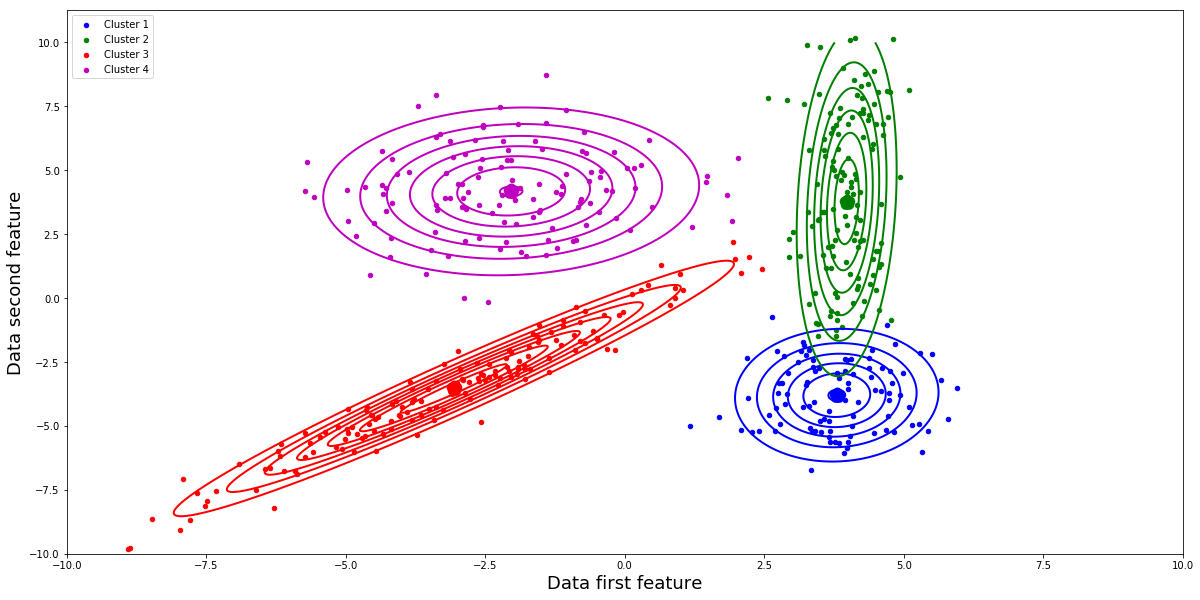

In [33]:
mu, labels, distortion = model.kmeans(model.Xt)
# Initialization of EM algorithm by random parameters and K-Means
alpha_init = [0.3,0.4, 0.2, 0.1]
mu_init = mu
sigma_init = np.array([[[1,0.3],[0.3,1]],[[1,0.3],[0.3,1]], [[1,-0.4],[-0.4,1]], [[0.1,0],[0,0.1]]])
theta_opt, likelihoods = model.trainEM(model.Xt, [alpha_init,mu_init,sigma_init])
plt.figure(figsize=(16,8))
plt.plot(likelihoods, color = 'blue', linewidth=2)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Complete likelihood of the GMM", fontsize=16)
plt.show()
model.plotPrediction(model.Xt, theta_opt)

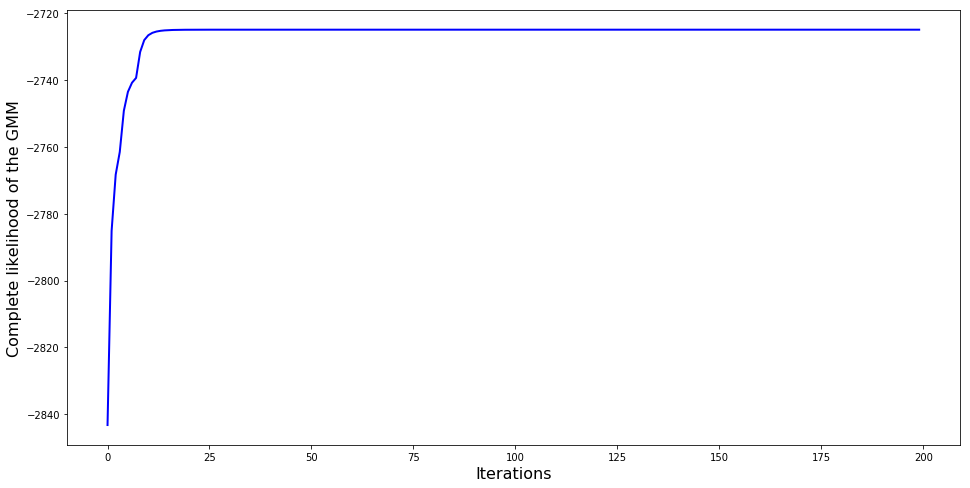

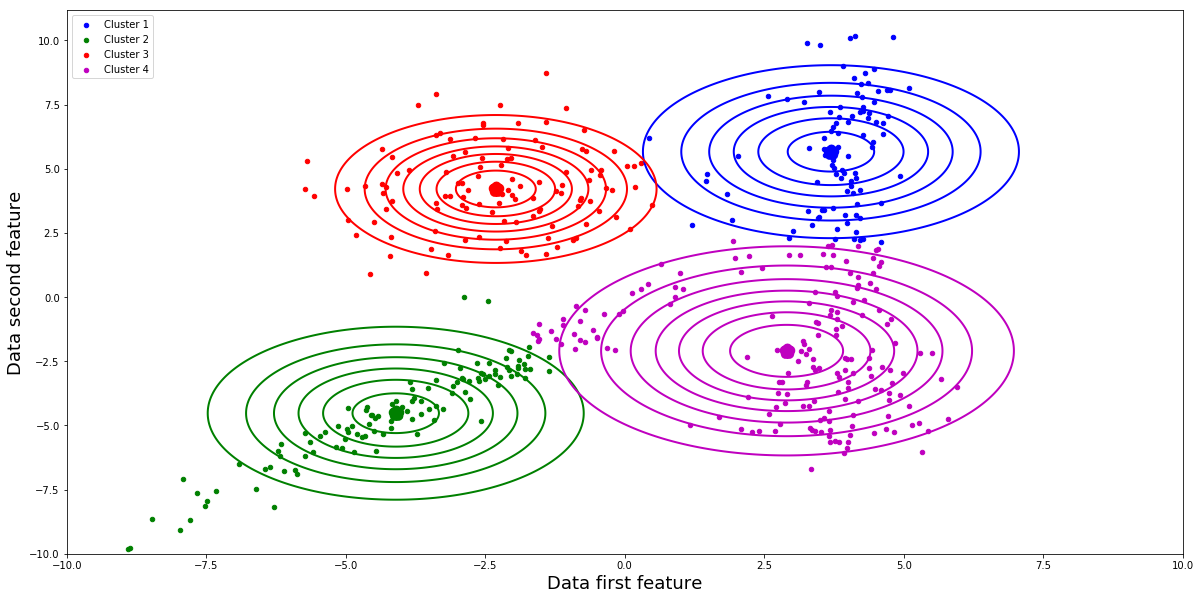

In [39]:
mu, labels, distortion = model.kmeans(model.Xt)
# Initialization of EM algorithm by random parameters and K-Means
alpha_init = [0.3,0.4, 0.2, 0.1]
mu_init = mu
sigma_init = np.array([[[10,0],[0,10]],[[1,0],[0,1]], [[3,0],[0,3]], [[6,0],[0,6]]])
# sigma_init = theta_opt[2]
isotropic_theta_opt, isotropic_likelihoods = model.trainIsotropicEM(model.Xt, [alpha_init,mu_init,sigma_init], Niter=200)
plt.figure(figsize=(16,8))
plt.plot(isotropic_likelihoods, color = 'blue', linewidth=2)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Complete likelihood of the GMM", fontsize=16)
plt.show()
model.plotPrediction(model.Xt, isotropic_theta_opt)

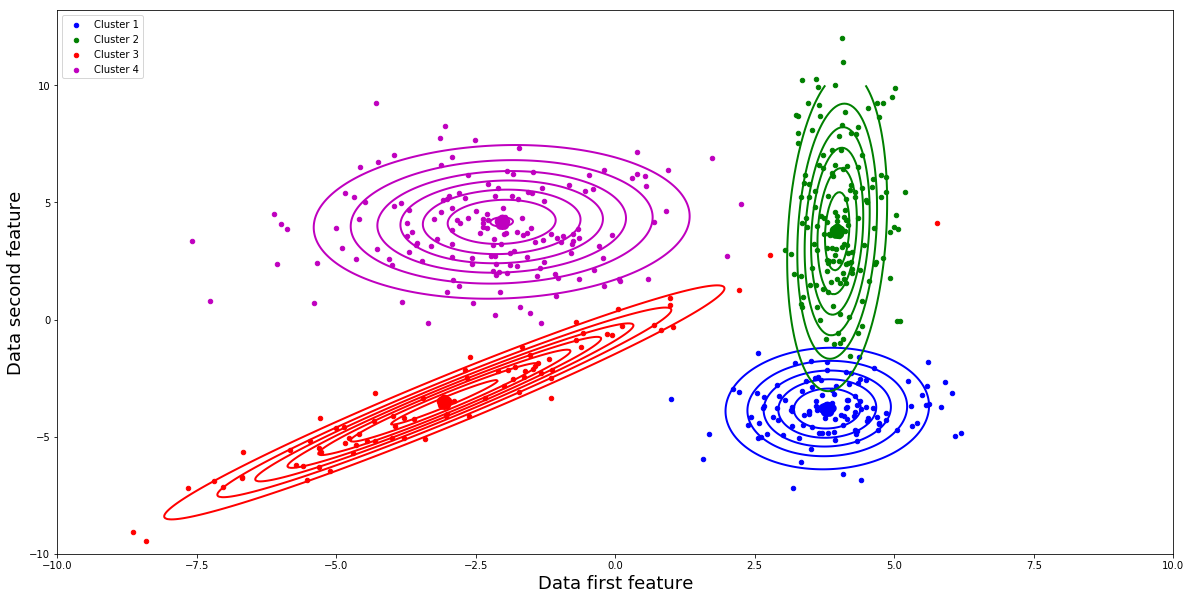

In [40]:
model.plotPrediction(model.Xv, theta_opt)

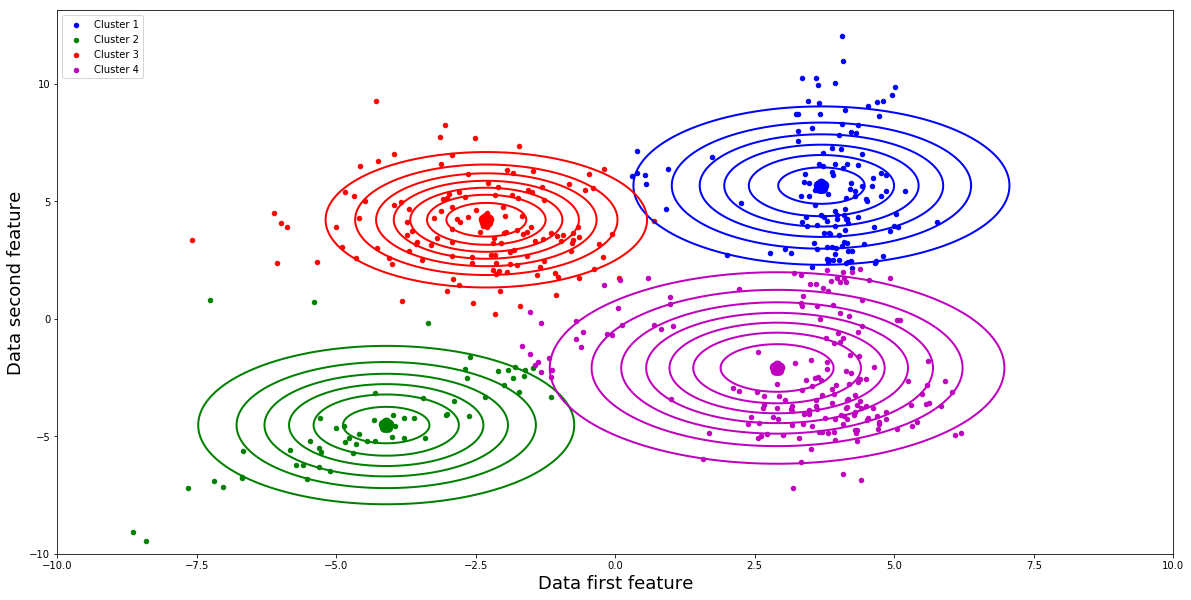

In [41]:
model.plotPrediction(model.Xv, isotropic_theta_opt)

In [45]:
print(model.likelihood(model.Xt, theta_opt)/model.Xt.shape[0])
print(model.likelihood(model.Xv, theta_opt)/model.Xv.shape[0])

print(model.likelihood(model.Xt, isotropic_theta_opt)/model.Xt.shape[0])
print(model.likelihood(model.Xv, isotropic_theta_opt)/model.Xv.shape[0])

-4.74176819488
-4.90712647265
-5.44975560174
-5.4947543017
